In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#if you dont have dataset, you can download that from kaggle
import os
import kagglehub
import shutil



# Define the paths for the new directories
datasets_folder_path = '/content/drive/My Drive/Datasets'
alzheimer_folder_path = os.path.join(datasets_folder_path, 'Alzheimer Multi Class Classification dataset')

# Create the directories
os.makedirs(alzheimer_folder_path, exist_ok=True)

# Download latest version
temp_path = kagglehub.dataset_download("lukechugh/best-alzheimer-mri-dataset-99-accuracy")

# Move the downloaded files to the 'brain tumor dataset' folder
for filename in os.listdir(temp_path):
    shutil.move(os.path.join(temp_path, filename), os.path.join(alzheimer_folder_path, filename))

print("Dataset files downloaded to:", alzheimer_folder_path)


100%|██████████| 71.5M/71.5M [00:01<00:00, 65.5MB/s]

Extracting files...


Dataset files downloaded to: /content/drive/My Drive/Datasets/Alzheimer Multi Class Classification dataset


In [ ]:
! pip install torchviz
! pip install split-folders
! pip install torchsummary
! pip install imblearn

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4132 sha256=1e6ba9aae04ac10bafae0174e24ec96d08f4169cb03a5e04f9829bc8c595fb8c
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import copy
import os
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from sklearn.model_selection import train_test_split
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
from torchvision import utils
from torchvision.datasets import ImageFolder
from torchsummary import summary
import splitfolders
import torch.nn.functional as F
import pathlib
from torch import optim
import torchvision.models as models
from torchviz import make_dot
from torchvision import models
from torchviz import make_dot
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay , classification_report



In [ ]:
# Define the path to the directories
train_dir = '/content/drive/MyDrive/Datasets/Alzheimer Multi Class Classification dataset/Combined Dataset/train'
test_dir = '/content/drive/MyDrive/Datasets/Alzheimer Multi Class Classification dataset/Combined Dataset/test'

# Function to create a DataFrame with image paths and labels
def create_dataframe(directory):
    data = []
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        if os.path.isdir(label_dir):  # Check if it's a directory
            for file in os.listdir(label_dir):
                if file.endswith(('.png', '.jpg', '.jpeg')):  # Include image file types
                    data.append({'file_path': os.path.join(label_dir, file), 'label': label})
    return pd.DataFrame(data)

# Create DataFrames for train and test datasets
train_df = create_dataframe(train_dir)
test_df = create_dataframe(test_dir)

# Print out the first few rows of the DataFrames
print("Train DataFrame:")
print(train_df.head())
print("\nTest DataFrame:")
print(test_df.head())


Train DataFrame:
                                           file_path            label
0  /content/drive/MyDrive/Datasets/Alzheimer Mult...  Mild Impairment
1  /content/drive/MyDrive/Datasets/Alzheimer Mult...  Mild Impairment
2  /content/drive/MyDrive/Datasets/Alzheimer Mult...  Mild Impairment
3  /content/drive/MyDrive/Datasets/Alzheimer Mult...  Mild Impairment
4  /content/drive/MyDrive/Datasets/Alzheimer Mult...  Mild Impairment

Test DataFrame:
                                           file_path                label
0  /content/drive/MyDrive/Datasets/Alzheimer Mult...  Moderate Impairment
1  /content/drive/MyDrive/Datasets/Alzheimer Mult...  Moderate Impairment
2  /content/drive/MyDrive/Datasets/Alzheimer Mult...  Moderate Impairment
3  /content/drive/MyDrive/Datasets/Alzheimer Mult...  Moderate Impairment
4  /content/drive/MyDrive/Datasets/Alzheimer Mult...  Moderate Impairment


In [ ]:
train_df.shape

(10240, 2)

In [ ]:
test_df.shape

(1279, 2)

In [ ]:
train_df.describe()

,file_path,label
count,10240,10240
unique,10240,4
top,/content/drive/MyDrive/Datasets/Alzheimer Mult...,Mild Impairment
freq,1,2560


In [ ]:
test_df.describe()

,file_path,label
count,1279,1279
unique,1279,4
top,/content/drive/MyDrive/Datasets/Alzheimer Mult...,No Impairment
freq,1,640


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10240 entries, 0 to 10239
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_path  10240 non-null  object
 1   label      10240 non-null  object
dtypes: object(2)
memory usage: 160.1+ KB


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1279 entries, 0 to 1278
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_path  1279 non-null   object
 1   label      1279 non-null   object
dtypes: object(2)
memory usage: 20.1+ KB


In [ ]:
train_df.isnull().sum()

,0
file_path,0
label,0


In [ ]:
test_df.isnull().sum()

,0
file_path,0
label,0


In [ ]:
train_df_copy = copy.deepcopy(train_df)
test_df_copy = copy.deepcopy(test_df)

In [ ]:
print(f'how many rows are duplicated in train dataset ? : {train_df.duplicated().sum()}')
print(f'how many rows are duplicated in test dataset? : {test_df.duplicated().sum()}')

how many rows are duplicated in train dataset ? : 0
how many rows are duplicated in test dataset? : 0


In [ ]:
train_df_label_counts = train_df['label'].value_counts()
test_df_label_counts = test_df['label'].value_counts()
print(f'how many data do we have in train dataset per class ? : {train_df_label_counts}')
print('-'*100)
print(f'how many data do we have in test dataset per class ? : {test_df_label_counts}')

how many data do we have in train dataset per class ? : label
Mild Impairment         2560
No Impairment           2560
Very Mild Impairment    2560
Moderate Impairment     2560
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
how many data do we have in test dataset per class ? : label
No Impairment           640
Very Mild Impairment    448
Mild Impairment         179
Moderate Impairment      12
Name: count, dtype: int64


In [ ]:
classes_names = train_df['label'].unique()
print(f'classes names in dataset : {classes_names}')


classes names in dataset : ['Mild Impairment' 'No Impairment' 'Very Mild Impairment'
 'Moderate Impairment']


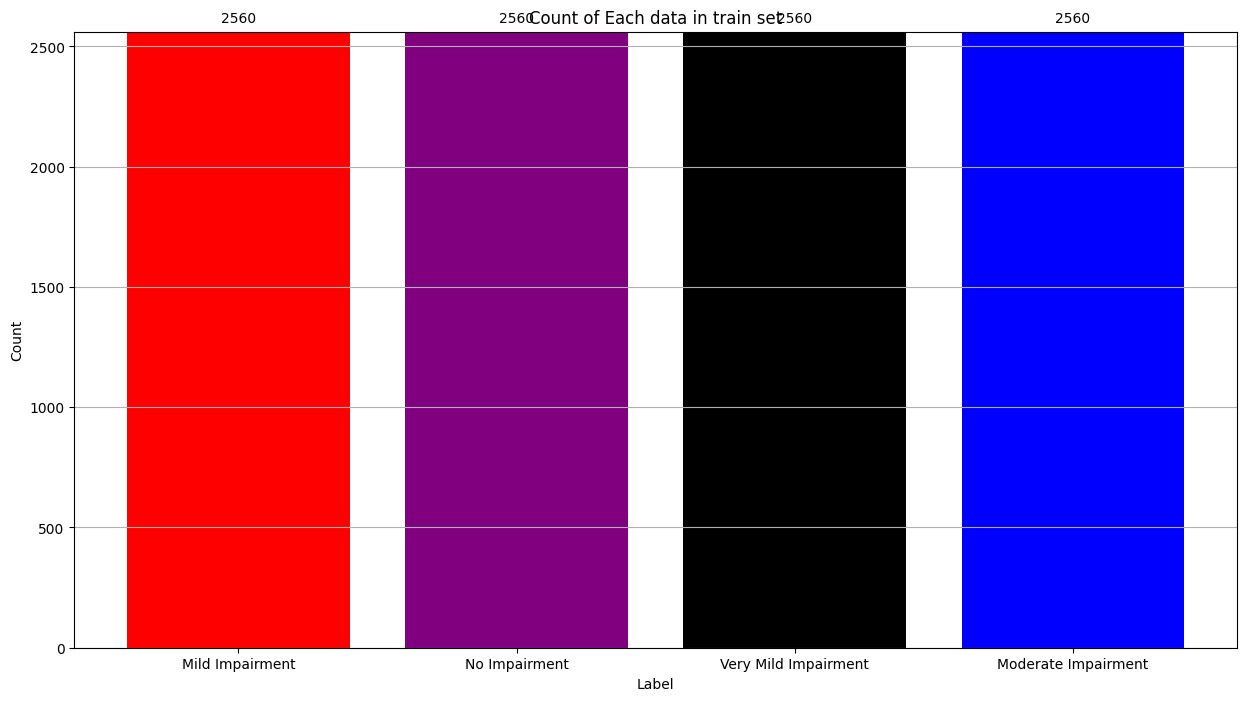

In [ ]:
# Define a color for each label
colors = {
    'Mild Impairment': 'red',
    'Very Mild Impairment': 'black',
    'Moderate Impairment' : 'blue',
    'No Impairment' : 'purple'
}

# Create the plot
plt.figure(figsize=(15, 8))
bars = plt.bar(train_df_label_counts.index, train_df_label_counts.values, color=[colors[label] for label in train_df_label_counts.index])

# Set y-axis limit
plt.ylim(0, train_df_label_counts.max() + 1)

# Annotate bars with their heights
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 5),  # Offset text slightly above the bar
                 textcoords='offset points',
                 ha='center',
                 va='bottom')

# Show the plot
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Count of Each data in train set')
plt.grid(axis='y')
plt.show()


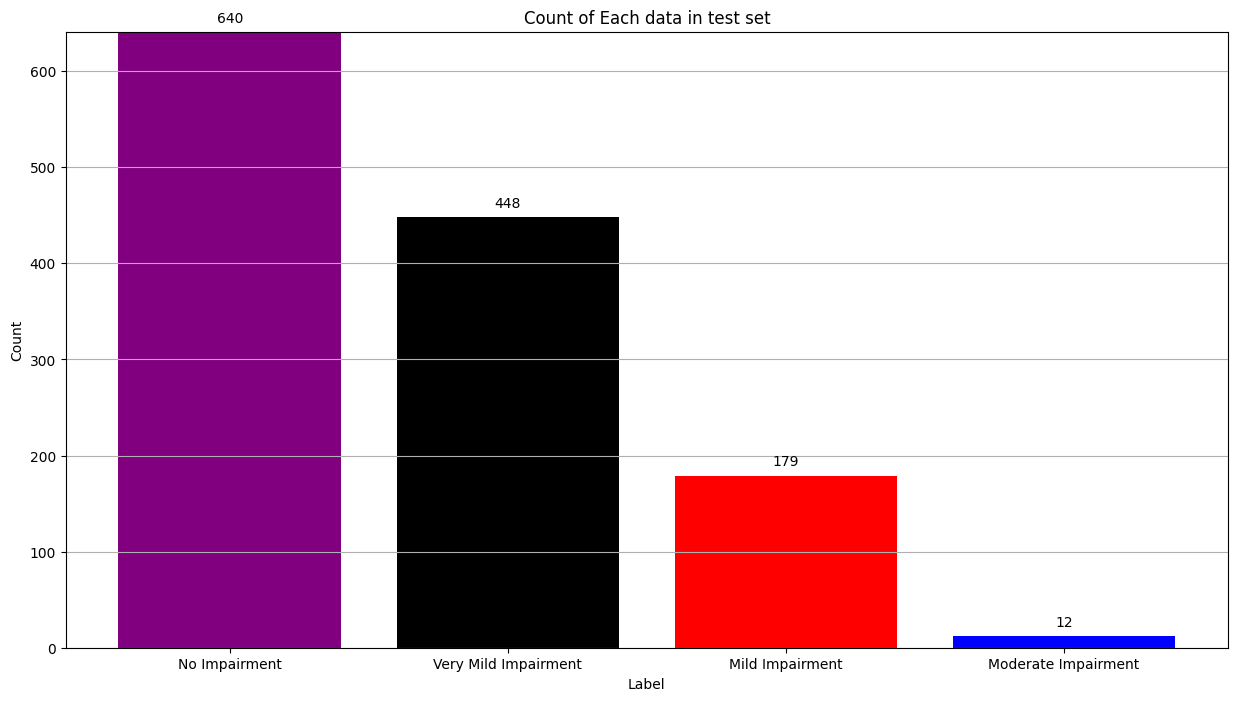

In [ ]:
# Define a color for each label
colors = {
    'Mild Impairment': 'red',
    'Very Mild Impairment': 'black',
    'Moderate Impairment' : 'blue',
    'No Impairment' : 'purple'
}

# Create the plot
plt.figure(figsize=(15, 8))
bars = plt.bar(test_df_label_counts.index, test_df_label_counts.values, color=[colors[label] for label in test_df_label_counts.index])

# Set y-axis limit
plt.ylim(0, test_df_label_counts.max() + 1)

# Annotate bars with their heights
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 5),  # Offset text slightly above the bar
                 textcoords='offset points',
                 ha='center',
                 va='bottom')

# Show the plot
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Count of Each data in test set')
plt.grid(axis='y')
plt.show()


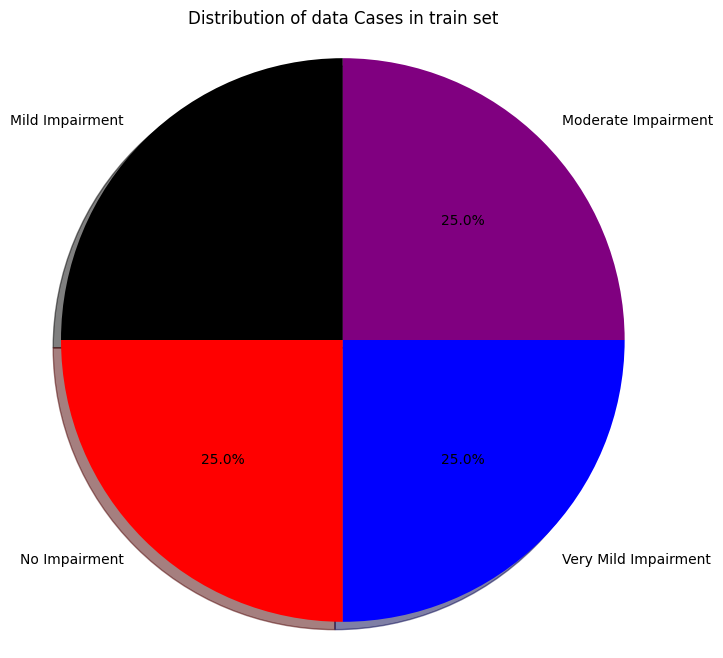

In [ ]:
# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(train_df_label_counts,
        labels=train_df_label_counts.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=['black', 'red','blue','purple'],  # Specify colors for each label
        shadow=True)

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')
plt.title('Distribution of data Cases in train set')
plt.show()




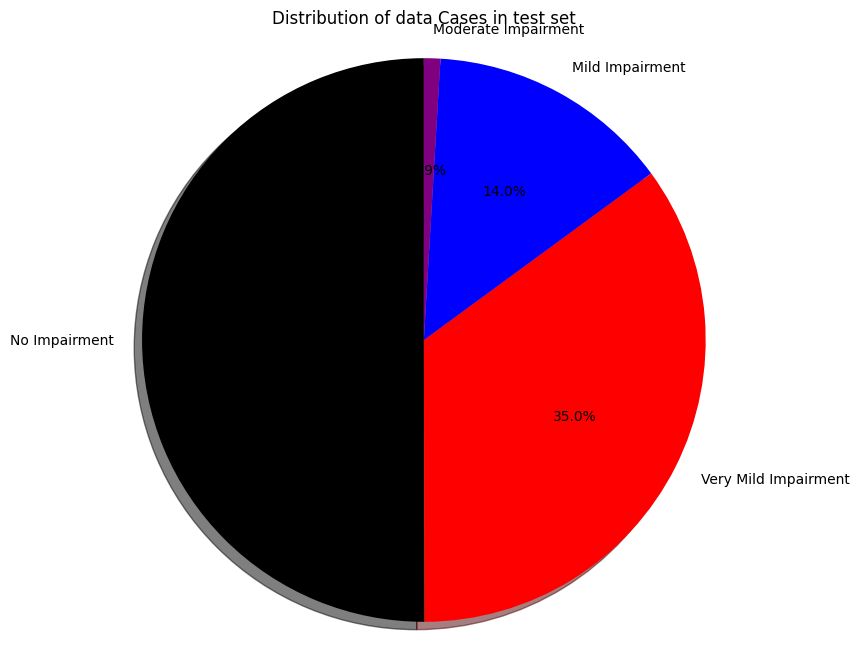

In [ ]:
# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(test_df_label_counts,
        labels=test_df_label_counts.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=['black', 'red','blue','purple'],  # Specify colors for each label
        shadow=True)

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')
plt.title('Distribution of data Cases in test set')
plt.show()


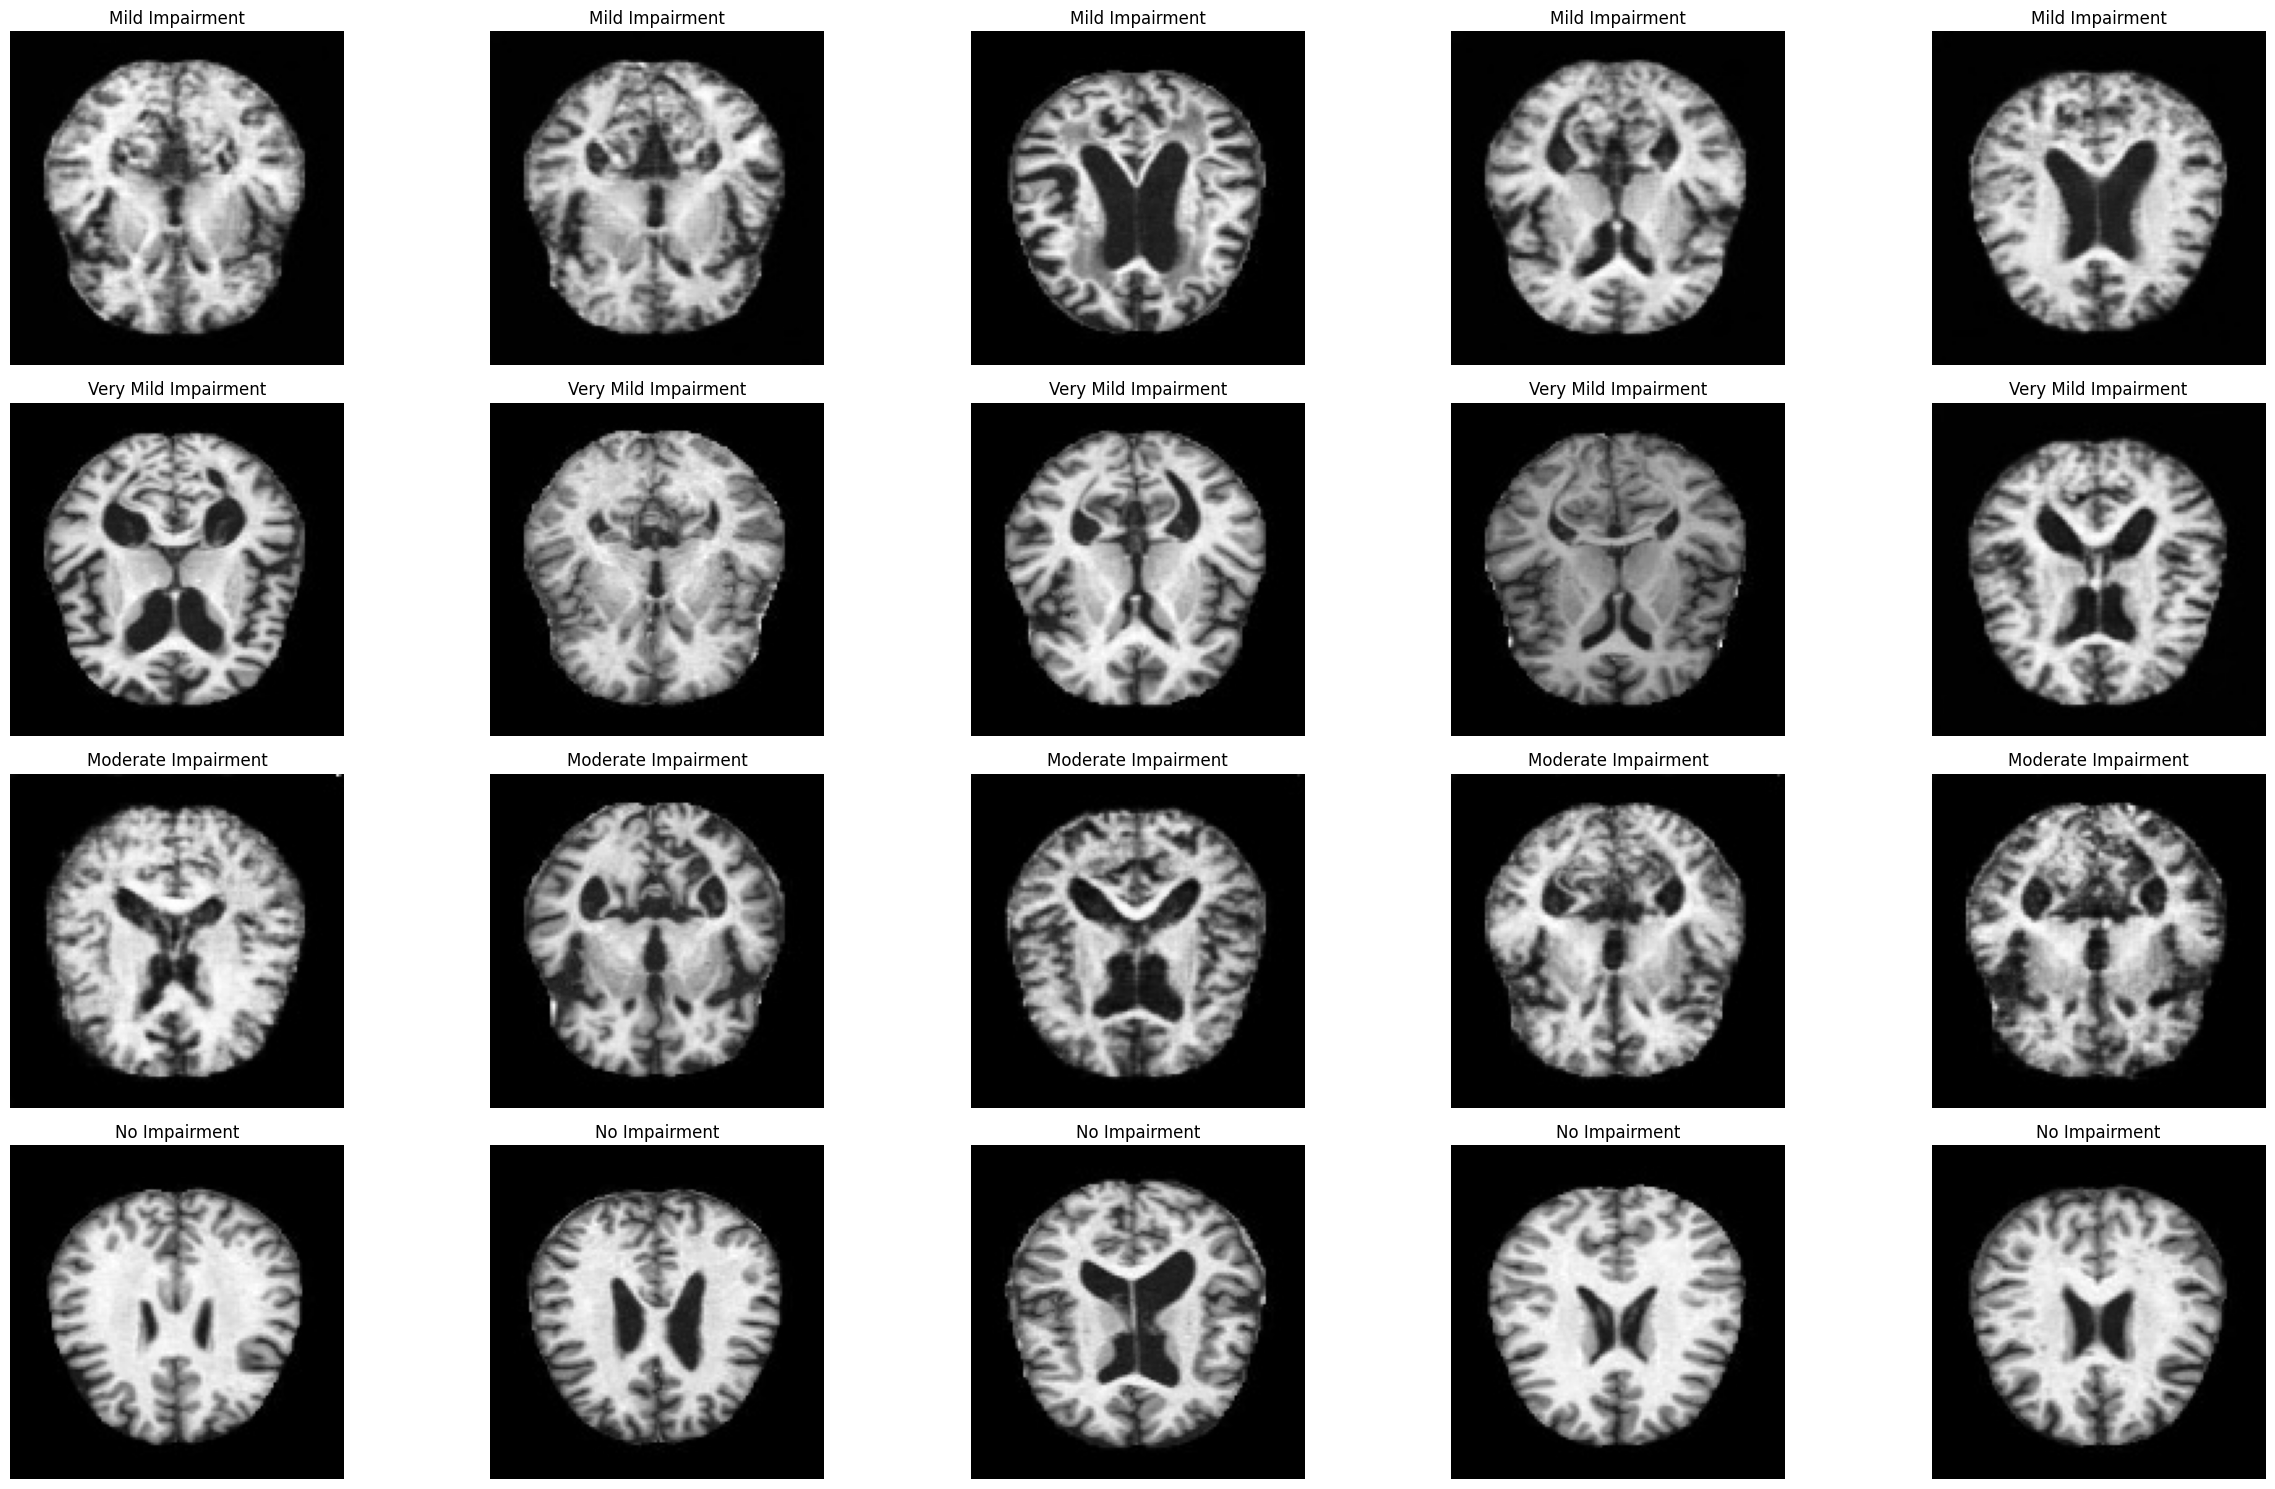

In [ ]:

# Separate images by class
Mild_Impairment = train_df[train_df['label'] == 'Mild Impairment']['file_path'].values
Very_Mild_Impairment = train_df[train_df['label'] == 'Very Mild Impairment']['file_path'].values
Moderate_Impairment = train_df[train_df['label'] == 'Moderate Impairment']['file_path'].values
No_Impairment = train_df[train_df['label'] == 'No Impairment']['file_path'].values

# Randomly sample 5 images from each category
Mild_Impairment = np.random.choice(Mild_Impairment, min(5, len(Mild_Impairment)), replace=False)
Very_Mild_Impairment = np.random.choice(Very_Mild_Impairment, min(5, len(Very_Mild_Impairment)), replace=False)
Moderate_Impairment = np.random.choice(Moderate_Impairment, min(5, len(Moderate_Impairment)), replace=False)
No_Impairment = np.random.choice(No_Impairment, min(5, len(No_Impairment)), replace=False)

# Create subplots
fig, axes = plt.subplots(4, 5, figsize=(25, 15))  # 4 rows and 5 columns

# Function to display images in grayscale
def display_image(ax, img_path, title):
    img = mpimg.imread(img_path)
    if img.ndim == 3:  # Check if the image has 3 channels
        img = np.mean(img, axis=2)  # Convert to grayscale by averaging the channels
    ax.imshow(img, cmap='gray')  # Use the 'gray' colormap
    ax.axis('off')
    ax.set_title(title)

# Display images with correct labels
labels = ['Mild Impairment', 'Very Mild Impairment', 'Moderate Impairment', 'No Impairment']

# Display Mild Impairment images
for ax, img_path in zip(axes[0], Mild_Impairment):
    display_image(ax, img_path, labels[0])

# Display Very Mild Impairment images
for ax, img_path in zip(axes[1], Very_Mild_Impairment):
    display_image(ax, img_path, labels[1])

# Display Moderate Impairment images
for ax, img_path in zip(axes[2], Moderate_Impairment):
    display_image(ax, img_path, labels[2])

# Display No Impairment images
for ax, img_path in zip(axes[3], No_Impairment):
    display_image(ax, img_path, labels[3])

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


#transforming and splitting

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:

from sklearn.model_selection import train_test_split, KFold
# Define transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images horizontally
    transforms.RandomVerticalFlip(p=0.5),  # Randomly flip images vertically
    transforms.RandomRotation(degrees=30),  # Randomly rotate images
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly change brightness, contrast, etc.
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(dataframe['label'].unique())

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.dataframe.iloc[idx, 1]

        if not os.path.isfile(img_path):
            raise FileNotFoundError(f"Image file not found: {img_path}")

        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        label = self.label_encoder.transform([label])[0]
        label = torch.tensor(label, dtype=torch.long)

        return img, label

# Create datasets
train_dataset = CustomDataset(train_df, transform=transform)
test_dataset = CustomDataset(test_df, transform=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]))

# Stratified split
train_indices, val_indices = train_test_split(
    list(range(len(train_df))),
    test_size=0.15,
    random_state=42,
    stratify=train_df['label'].values
)

train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(train_dataset, val_indices)

# Data loaders
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)


# Optional: Print the sizes of the datasets
print(f"Training dataset size: {len(train_loader.dataset)}")
print(f"Validation dataset size: {len(val_loader.dataset)}")
print(f"Test dataset size: {len(test_loader.dataset)}")


Training dataset size: 8704
Validation dataset size: 1536
Test dataset size: 1279


In [ ]:
# # Define transformations for the dataset
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),  # Resize images to 224x224
#     transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images horizontally
#     transforms.RandomVerticalFlip(p=0.5),  # Randomly flip images vertically
#     transforms.RandomRotation(degrees=30),  # Randomly rotate images
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly change brightness, contrast, etc.
#     transforms.ToTensor(),  # Convert images to PyTorch tensors
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
# ])

# # Custom dataset class
# class CustomDataset(Dataset):
#     def __init__(self, dataframe, transform=None):
#         self.dataframe = dataframe
#         self.transform = transform
#         self.classes = dataframe['label'].unique()  # Store unique class names
#         self.label_encoder = LabelEncoder()
#         self.label_encoder.fit(self.classes)  # Fit the label encoder

#     def __len__(self):
#         return len(self.dataframe)

#     def __getitem__(self, idx):
#         img_path = self.dataframe.iloc[idx, 0]  # Get image path
#         label = self.dataframe.iloc[idx, 1]  # Get label

#         # Check if the path is a file
#         if not os.path.isfile(img_path):
#             raise FileNotFoundError(f"Image file not found: {img_path}")

#         img = Image.open(img_path).convert('RGB')  # Open image and convert to RGB

#         if self.transform:
#             img = self.transform(img)  # Apply transformations

#         # Convert label to integer and then to tensor
#         label = self.label_encoder.transform([label])[0]  # Transform the label to an integer
#         label = torch.tensor(label, dtype=torch.long)  # Convert to tensor

#         return img, label

# # Create the dataset from the resampled training DataFrame
# train_dataset = CustomDataset(train_df, transform=transform)

# test_dataset = CustomDataset(test_df, transform=transforms.Compose([
#     transforms.Resize((224, 224)),  # Resize images to 224x224
#     transforms.ToTensor(),  # Convert images to PyTorch tensors
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
# ]))  # Limited transformations for test set


# # Get indices for splitting and labels for stratification
# indices = list(range(len(train_df)))
# train_labels = train_df['label'].values  # Extract labels for stratification

# # Split into training and validation sets
# train_indices, val_indices = train_test_split(indices, test_size=0.15, random_state=42, stratify=train_labels)

# # Create training and validation subsets
# train_subset = Subset(train_dataset, train_indices)
# val_subset = Subset(train_dataset, val_indices)  # Create validation subset from the original train dataset

# # Create data loaders for each dataset
# train_loader = DataLoader(train_subset, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
# val_loader = DataLoader(val_subset, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)
# test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

# # Optional: Print the sizes of the datasets
# print(f"Training dataset size: {len(train_loader.dataset)}")
# print(f"Validation dataset size: {len(val_loader.dataset)}")
# print(f"Test dataset size: {len(test_loader.dataset)}")


Training dataset size: 8704
Validation dataset size: 1536
Test dataset size: 1279


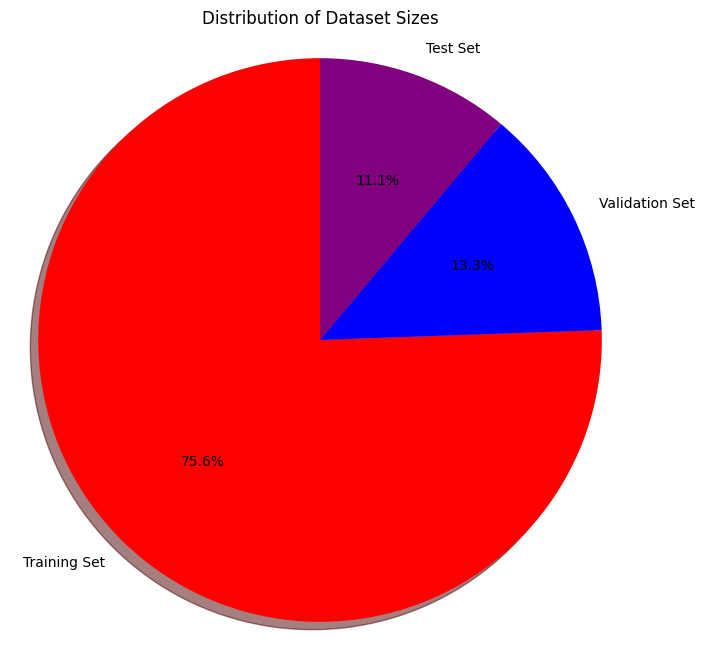

In [ ]:
# Function to create a pie chart for the dataset sizes
def plot_pie_chart(sizes, labels, title):
    plt.figure(figsize=(8, 8))
    plt.pie(sizes,
            labels=labels,
            autopct='%1.1f%%',
            startangle=90,
            shadow=True,
            colors=colors)  # Use the specified colors
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title(title)
    plt.show()

# Get the sizes of each dataset
train_size = len(train_loader.dataset)
val_size = len(val_loader.dataset)
test_size = len(test_loader.dataset)

# Create a list of sizes and corresponding labels
sizes = [train_size, val_size, test_size]
labels = ['Training Set', 'Validation Set', 'Test Set']
colors = ['red', 'blue', 'purple']  # Specify colors for each dataset



# Plot the pie chart for the dataset sizes
plot_pie_chart(sizes, labels, 'Distribution of Dataset Sizes')


tensor(0)


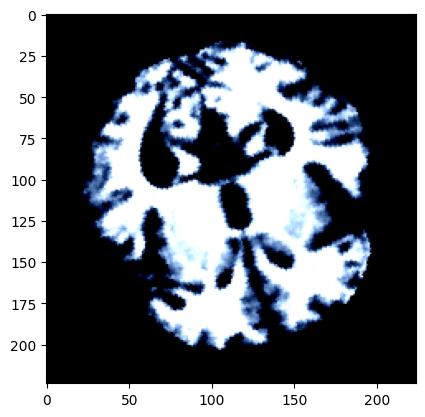

In [ ]:
img, label = train_subset[300]
plt.imshow(img.permute(1,2,0)) #convert into bgr format
print(label)

tensor(0)


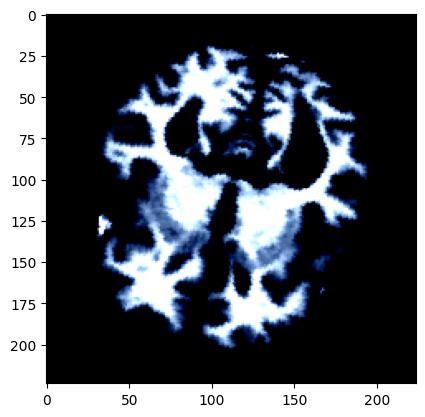

In [ ]:
img, label = val_subset[301]
plt.imshow(img.permute(1,2,0)) #convert into bgr format
print(label)

In [ ]:
print(f'how many batch do we have in train loader? :{len(train_loader)}')
print(f'how many batch do we have in validation loader? :{len(val_loader)}')
print(f'how many batch do we have in test loader? :{len(test_loader)}')


how many batch do we have in train loader? :272
how many batch do we have in validation loader? :48
how many batch do we have in test loader? :40


#Modeling

In [ ]:
class CNNmodel(nn.Module):
    def __init__(self):
        super(CNNmodel, self).__init__()

        # Convolutional layers with increased kernel size
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)  # Batch normalization after conv1

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)  # Batch normalization after conv2

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)  # Batch normalization after conv3

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)  # Batch normalization after conv4

        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(256)  # Batch normalization after conv5

        self.conv6 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(512)  # Batch normalization after conv5

        # Max pooling layers
        self.maxpool = nn.MaxPool2d(kernel_size=2)

        # Dropout layer
        self.dropout = nn.Dropout(p=0.5)

        # Activation Function
        self.leakyRelu = nn.LeakyReLU()

        # Fully connected layers
        self.fc1 = nn.Linear(512 * 3 * 3, 512)  # Adjusted input size based on the output of conv layers
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 4)

    def forward(self, x):
        # Convolutional layers with max pooling, batch normalization, and dropout
        x = self.leakyRelu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.leakyRelu(self.bn2(self.conv2(x)))
        x = self.maxpool(x)

        x = self.leakyRelu(self.bn3(self.conv3(x)))
        x = self.maxpool(x)

        x = self.leakyRelu(self.bn4(self.conv4(x)))
        x = self.maxpool(x)

        x = self.leakyRelu(self.bn5(self.conv5(x)))
        x = self.maxpool(x)

        x = self.leakyRelu(self.bn6(self.conv6(x)))
        x = self.maxpool(x)


        # Flatten
        out = x.view(x.size(0), -1)

        # Fully connected layers with dropout
        out = self.leakyRelu(self.fc1(out))
        out = self.dropout(out)  # Apply dropout
        out = self.leakyRelu(self.fc2(out))
        out = self.dropout(out)  # Apply dropout
        out = self.fc3(out)


        return out


In [ ]:
Model1 = CNNmodel()

In [ ]:

# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available!")
    # Get the current device
    current_device = torch.cuda.current_device()
    print(f"Current CUDA device: {current_device}")

    # Get the number of GPUs
    num_gpus = torch.cuda.device_count()
    print(f"Number of available GPUs: {num_gpus}")

    # Get the name of the GPU
    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available.")


CUDA is available!
Current CUDA device: 0
Number of available GPUs: 1
GPU 0: Tesla T4


In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move model to the appropriate device
Model1.to(device)

# Create a dummy input tensor on the same device
input_tensor = torch.randn(1, 3, 224, 224).to(device)

# Print model summary
summary(Model1, (3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
       BatchNorm2d-2         [-1, 16, 224, 224]              32
         LeakyReLU-3         [-1, 16, 224, 224]               0
         MaxPool2d-4         [-1, 16, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           4,640
       BatchNorm2d-6         [-1, 32, 112, 112]              64
         LeakyReLU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          18,496
      BatchNorm2d-10           [-1, 64, 56, 56]             128
        LeakyReLU-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Conv2d-13          [-1, 128, 28, 28]          73,856
      BatchNorm2d-14          [-1, 128,

#Network visualize with torchviz and matplotlib image

In [ ]:
# Create a dummy input
x = torch.randn(1, 3, 224, 224).to(device)  # Batch size of 1

# Get the output
y = Model1(x)

# Visualize the model
dot = make_dot(y, params=dict(list(Model1.named_parameters())))
dot.render("CNNAlzheimer", format="png")  # Save as PNG


'CNNAlzheimer.png'

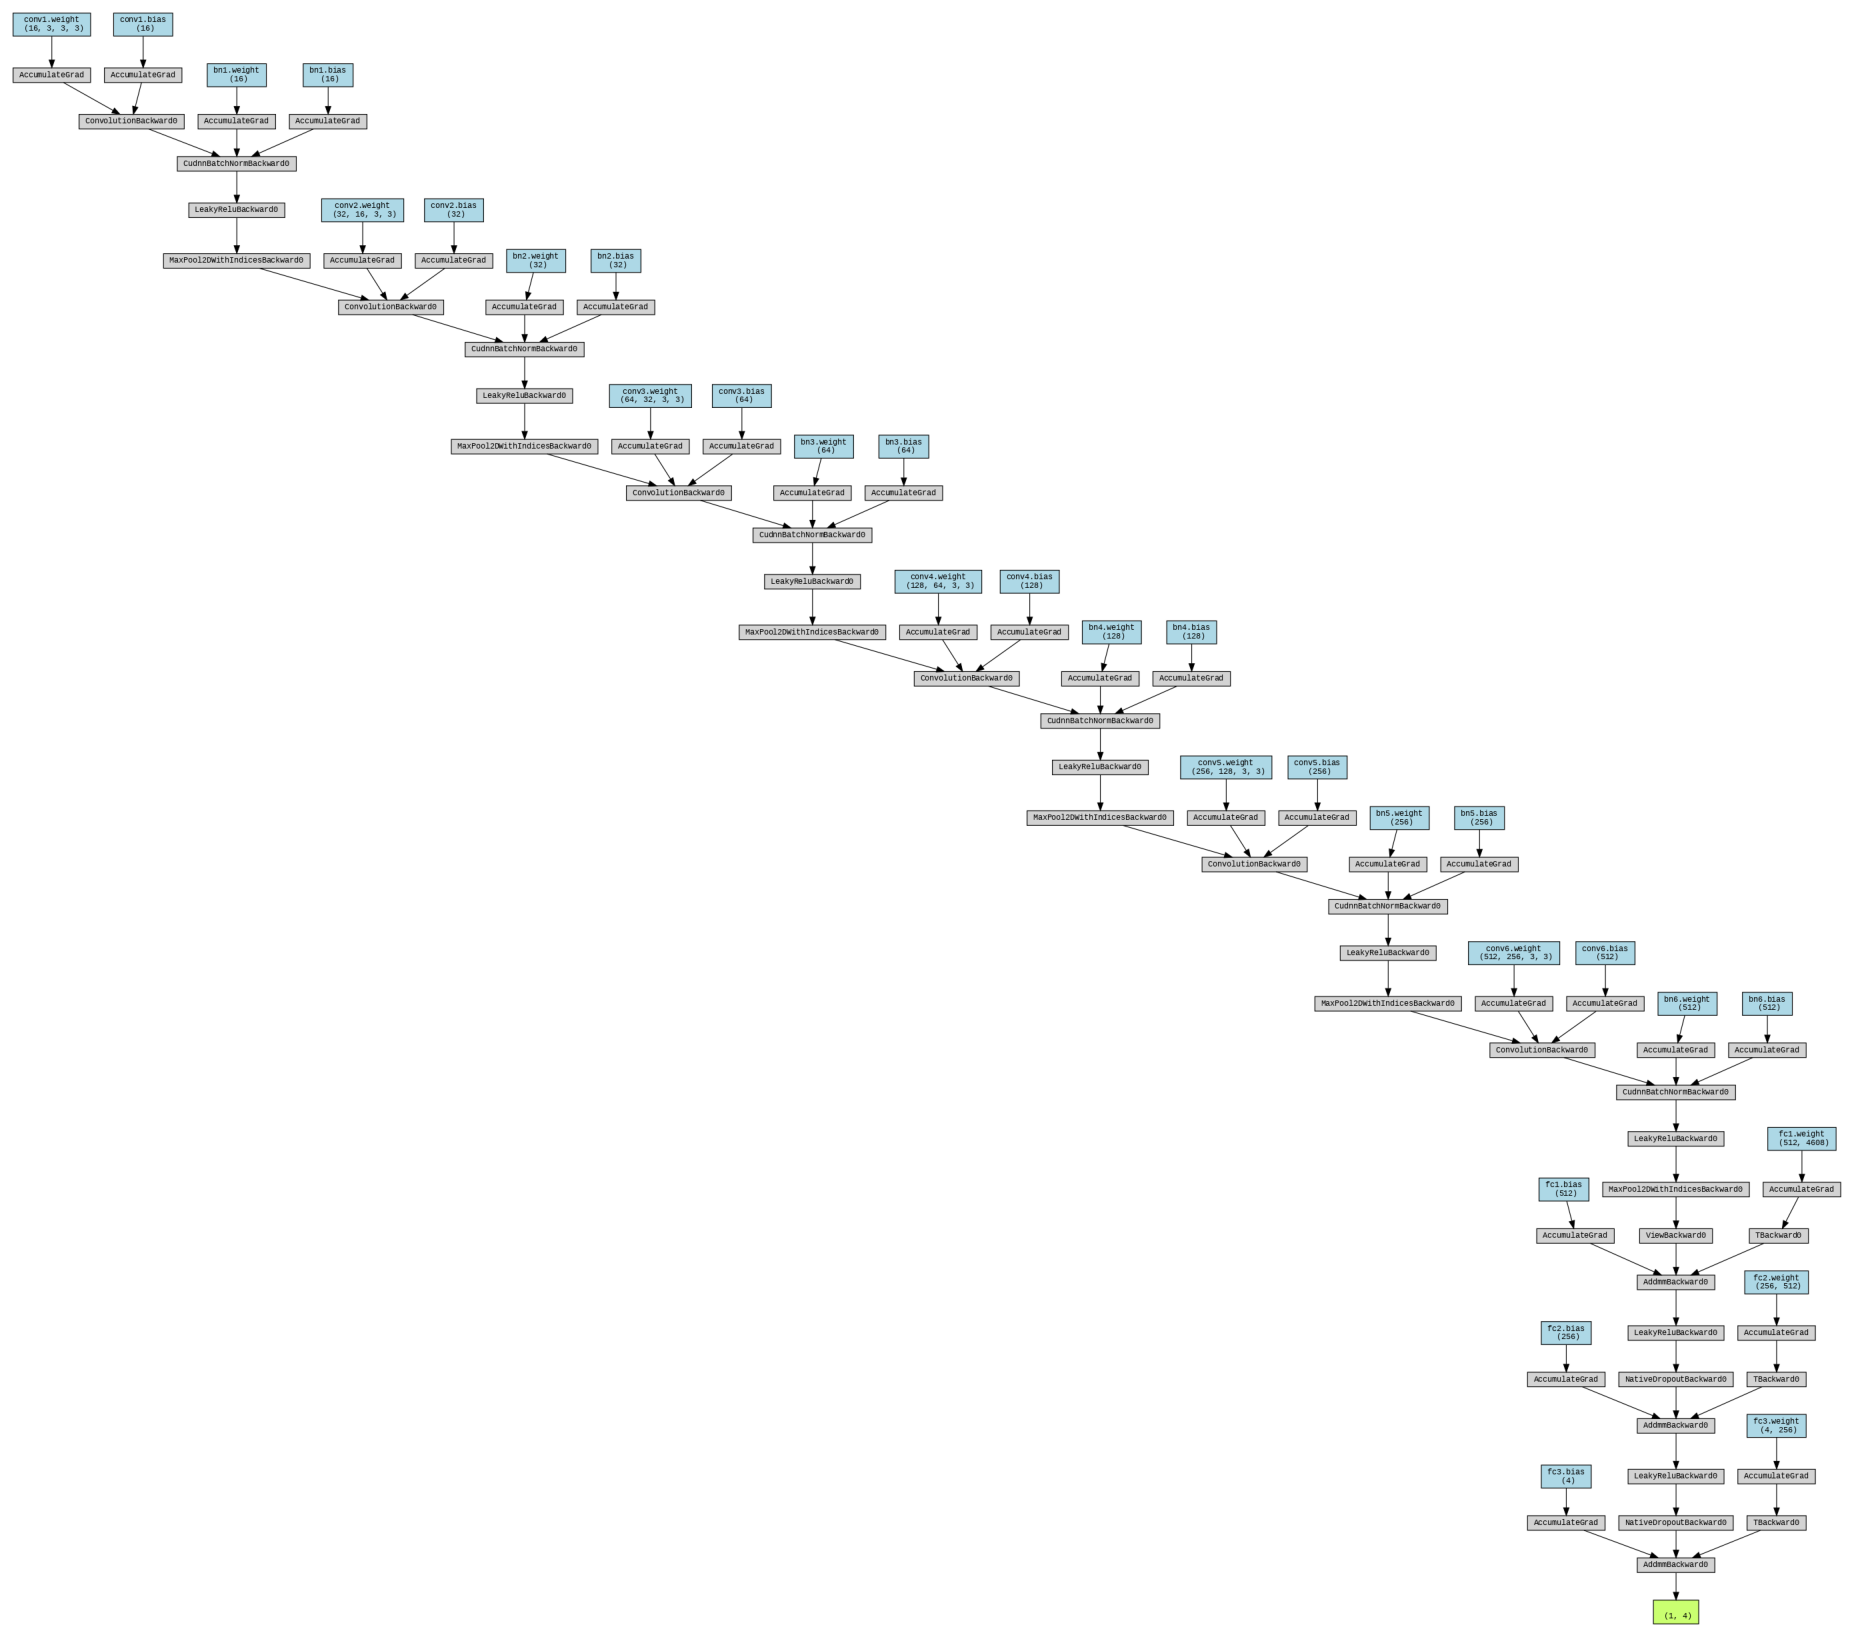

In [ ]:

# Display the image using matplotlib
img = mpimg.imread("CNNAlzheimer.png")
plt.figure(figsize=(35, 21))
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

#Write Function for Training

###Select :

1.   Loss Function
2.   Optimizer
3.Activation Function



In [ ]:
num_epoch = 25
loss_fn = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(Model1.parameters(), lr=lr, weight_decay=1e-4)  # L2 regularization
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.4, patience=2, verbose=True)


In [ ]:
# Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0  # Reset counter if validation loss improves
        else:
            self.counter += 1  # Increment counter if no improvement
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("Early stopping triggered")

# Initialize early stopping
early_stopping = EarlyStopping(patience=5, verbose=True)


In [ ]:
train_loss_list = []
val_loss_list = []
acc_list = []

In [ ]:
# Initialize variables to save the best model
best_val_loss = float('inf')  # Start with infinity
best_model_weights = None

# Training loop
for epoch in range(num_epoch):
    train_loss = 0
    val_loss = 0
    total = 0
    correct = 0

    # Training phase
    Model1.train()  # Set model to training mode
    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = Model1(images)
        loss = loss_fn(outputs, labels)
        train_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # Validation phase
    Model1.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = Model1(images)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()

            prediction = torch.max(outputs.data, 1)[1]
            total += len(labels)
            correct += (prediction == labels).sum().item()  # Ensure to convert to int

    # Step the scheduler based on validation loss
    scheduler.step(val_loss)

    # Calculate performance of training model
    accuracy = 100 * correct / float(total)
    train_loss_list.append(train_loss / len(train_loader))
    val_loss_list.append(val_loss / len(val_loader))  # Store validation loss
    acc_list.append(accuracy)

    print('-'*100)
    print('Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}, Accuracy: {:.2f}%'.format(
        epoch + 1, num_epoch, train_loss / len(train_loader), val_loss / len(val_loader), accuracy))

    # Check if the current validation loss is the best we've seen so far
    avg_val_loss = val_loss / len(val_loader)
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_wts = Model1.state_dict()
        print("Best model weights saved.")


    # Check for early stopping
    early_stopping(avg_val_loss)
    if early_stopping.early_stop:
        print("Early stopping at epoch:", epoch + 1)
        break
# After training, save the best model weights to a file
torch.save(best_model_weights, 'best_model_weights.pth')
print("Best model weights saved.")


----------------------------------------------------------------------------------------------------
Epoch [1/25], Train Loss: 1.4443, Val Loss: 1.3447, Accuracy: 30.60%
Best model weights saved.
----------------------------------------------------------------------------------------------------
Epoch [2/25], Train Loss: 1.2076, Val Loss: 1.3756, Accuracy: 38.54%
----------------------------------------------------------------------------------------------------
Epoch [3/25], Train Loss: 0.9718, Val Loss: 0.8152, Accuracy: 62.17%
Best model weights saved.
----------------------------------------------------------------------------------------------------
Epoch [4/25], Train Loss: 0.8249, Val Loss: 0.7332, Accuracy: 65.95%
Best model weights saved.
----------------------------------------------------------------------------------------------------
Epoch [5/25], Train Loss: 0.7539, Val Loss: 0.6767, Accuracy: 66.21%
Best model weights saved.
----------------------------------------------

#visualize model performance on train and validation set

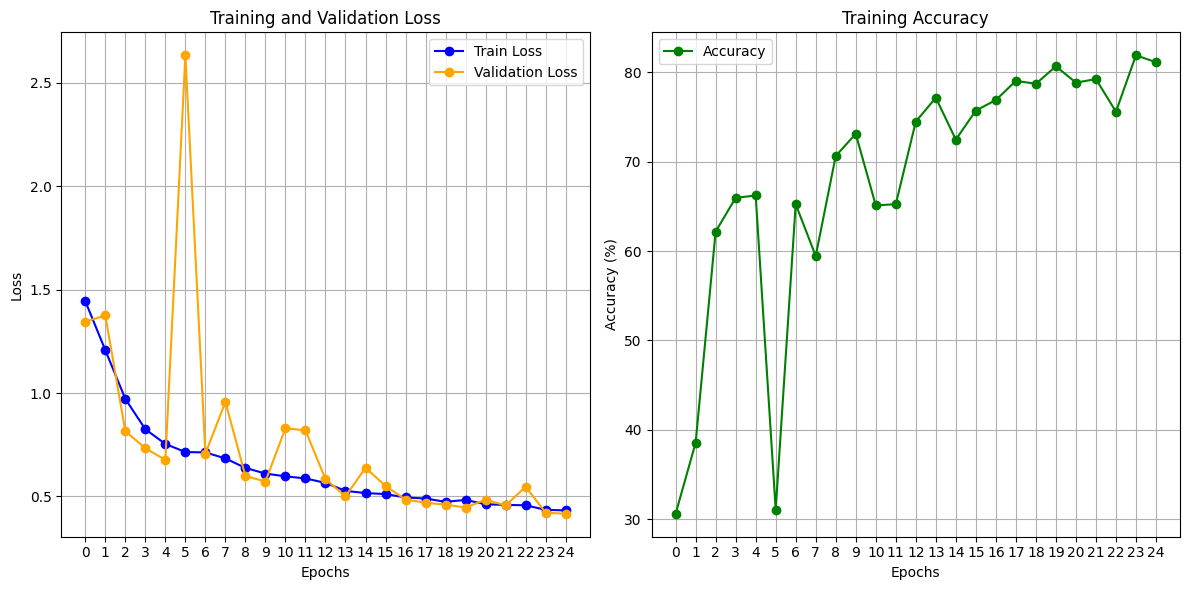

In [ ]:
# Plotting training and validation loss
plt.figure(figsize=(12, 6))

# Loss Plot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(range(num_epoch), train_loss_list, label='Train Loss', color='blue', marker='o')
plt.plot(range(num_epoch), val_loss_list, label='Validation Loss', color='orange', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(num_epoch))  # Ensure all epochs are labeled
plt.grid(True)
plt.legend()
plt.tight_layout()

# Accuracy Plot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.plot(range(num_epoch), acc_list, label='Accuracy', color='green', marker='o')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.xticks(range(num_epoch))  # Ensure all epochs are labeled
plt.grid(True)
plt.legend()
plt.tight_layout()

# Show the plots
plt.show()


#Evaluation

In [ ]:


# Assuming you have lists to store test losses and accuracies
test_loss_list = []  # Store test losses over epochs
test_accuracy_list = []  # Store test accuracies over epochs

# Test phase
Model1.eval()  # Set model to evaluation mode
test_loss = 0
total = 0
correct = 0
all_test_labels = []
all_test_predictions = []

with torch.no_grad():  # Disable gradient calculation
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = Model1(images)
        loss = loss_fn(outputs, labels)
        test_loss += loss.item()

        prediction = torch.max(outputs.data, 1)[1]
        total += len(labels)
        correct += (prediction == labels).sum().item()  # Count correct predictions

        # Store labels and predictions for metrics
        all_test_labels.extend(labels.cpu().numpy())
        all_test_predictions.extend(prediction.cpu().numpy())

# Calculate test accuracy
test_accuracy = 100 * correct / float(total)
test_loss_avg = test_loss / len(test_loader)
test_loss_list.append(test_loss / len(test_loader))
test_accuracy_list.append(test_accuracy)

# Print test results
print('Test Loss: {:.4f}, Test Accuracy: {:.2f}%'.format(
    test_loss / len(test_loader), test_accuracy))



Test Loss: 0.7111, Test Accuracy: 64.97%


#Visualize model performance on test set

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.51      0.58       179
           1       1.00      0.83      0.91        12
           2       0.74      0.74      0.74       640
           3       0.52      0.57      0.55       448

    accuracy                           0.65      1279
   macro avg       0.73      0.66      0.69      1279
weighted avg       0.66      0.65      0.65      1279



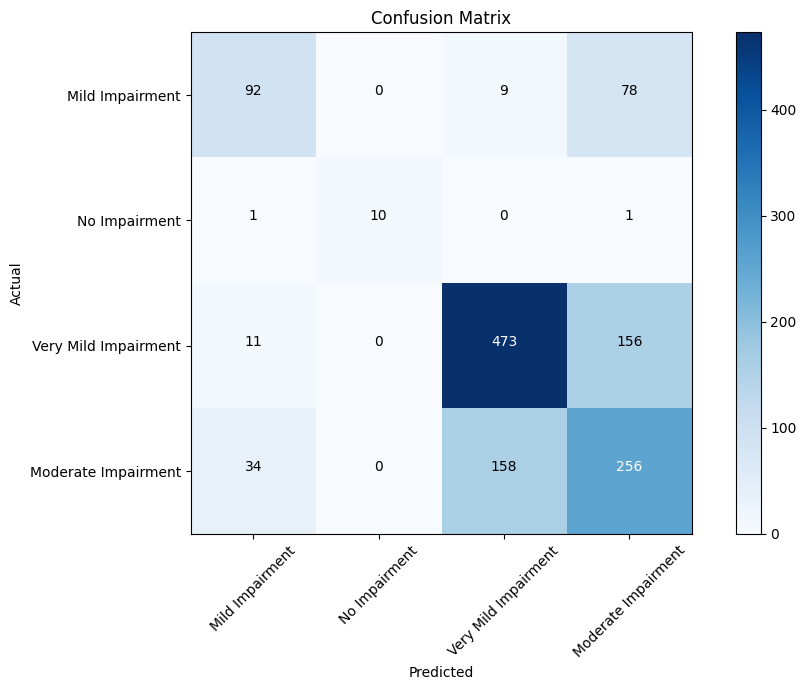

In [ ]:

# Convert to numpy arrays
y_true = np.array(all_test_labels)
y_pred = np.array(all_test_predictions)

# Generate classification report
report = classification_report(y_true, y_pred)
print("Classification Report:")
print(report)

# Visualize Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
class_names = train_df['label'].unique()  # Get unique class names

plt.figure(figsize=(10, 7))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

thresh = conf_matrix.max() / 2.  # Set threshold for text color
for i, j in np.ndindex(conf_matrix.shape):
    plt.text(j, i, f'{conf_matrix[i, j]}',
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()


#Xception Pre-trained Model and fine tuned it on data

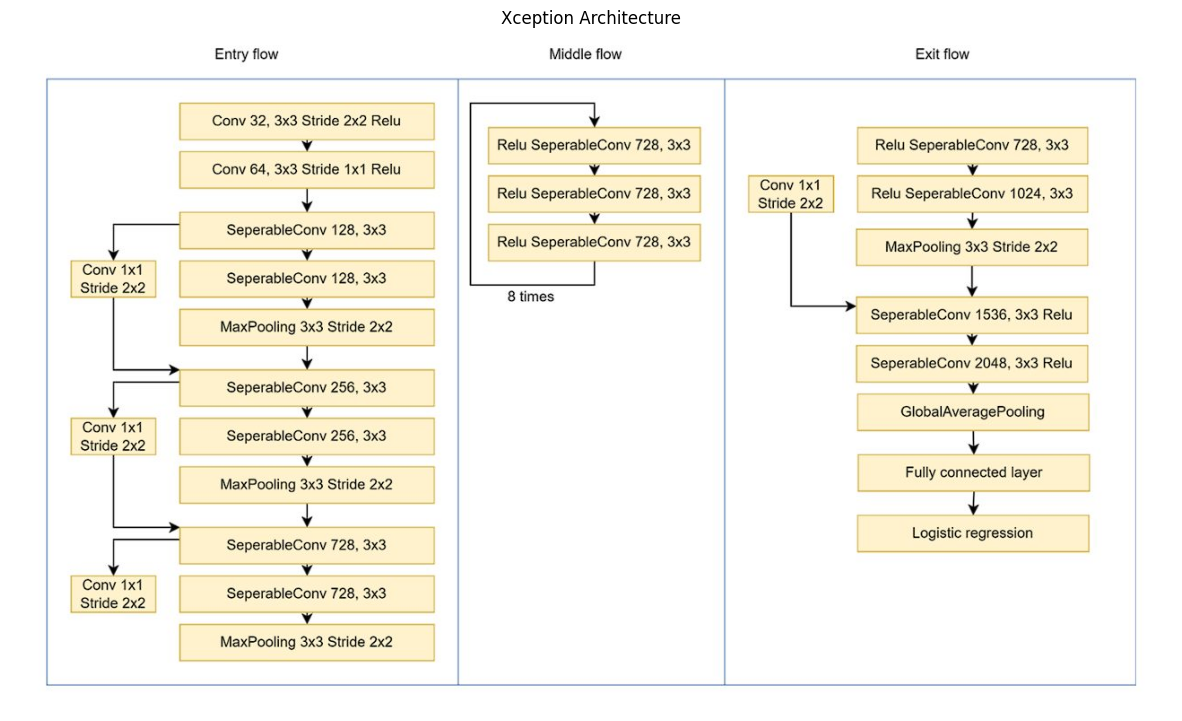

In [ ]:
from google.colab import files
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load and display the image
image_path = '/content/xception-architecture.jpg'
img = mpimg.imread(image_path)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.title('Xception Architecture')
plt.axis('off')  # Hide axes
plt.show()


In [ ]:
!pip install timm

In [ ]:
import timm


In [ ]:
# Initialize the pre-trained Xception model
model = timm.create_model('xception', pretrained=True)

# Modify the final fully connected layer
num_classes = 4  # Number of classes in your dataset
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move the model to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define hyperparameters
num_epoch = 10
loss_fn = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.4, patience=2, verbose=True)


In [ ]:
# Create data loaders for each dataset
train_loader = DataLoader(train_subset, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_subset, batch_size=8, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2, pin_memory=True)

In [ ]:
#Clear CUDA Cache for fixing The "CUDA out of memory" eror
torch.cuda.empty_cache()


In [ ]:

# Training loop
best_val_loss = float('inf')
best_model_weights = None

for epoch in range(num_epoch):
    train_loss = 0
    val_loss = 0
    total = 0
    correct = 0

    model.train()  # Set model to training mode
    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = loss_fn(outputs, labels)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()

            prediction = torch.max(outputs.data, 1)[1]
            total += len(labels)
            correct += (prediction == labels).sum().item()

    scheduler.step(val_loss)

    accuracy = 100 * correct / float(total)
    print('-'*100)
    print('Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}, Accuracy: {:.2f}%'.format(
        epoch + 1, num_epoch, train_loss / len(train_loader), val_loss / len(val_loader), accuracy))

    avg_val_loss = val_loss / len(val_loader)
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_weights = model.state_dict()
        print("Best model weights saved.")

# Save the best model weights to a file
torch.save(best_model_weights, 'best_model_weights.pth')
print("Best model weights saved.")



----------------------------------------------------------------------------------------------------
Epoch [1/10], Train Loss: 0.8679, Val Loss: 1.1128, Accuracy: 58.07%
Best model weights saved.
----------------------------------------------------------------------------------------------------
Epoch [2/10], Train Loss: 0.6823, Val Loss: 1.0022, Accuracy: 64.32%
Best model weights saved.
----------------------------------------------------------------------------------------------------
Epoch [3/10], Train Loss: 0.6326, Val Loss: 0.7546, Accuracy: 68.88%
Best model weights saved.
----------------------------------------------------------------------------------------------------
Epoch [4/10], Train Loss: 0.5705, Val Loss: 0.5326, Accuracy: 76.37%
Best model weights saved.
----------------------------------------------------------------------------------------------------
Epoch [5/10], Train Loss: 0.5433, Val Loss: 0.4926, Accuracy: 76.89%
Best model weights saved.
--------------------

#Evaluation Xception

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Evaluation phase
test_loss = 0
total = 0
correct = 0
all_test_labels = []
all_test_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = loss_fn(outputs, labels)
        test_loss += loss.item()

        prediction = torch.max(outputs.data, 1)[1]
        total += len(labels)
        correct += (prediction == labels).sum().item()

        # Store labels and predictions for metrics
        all_test_labels.extend(labels.cpu().numpy())
        all_test_predictions.extend(prediction.cpu().numpy())

# Calculate test accuracy and average loss
test_accuracy = 100 * correct / float(total)
test_loss_avg = test_loss / len(test_loader)

# Print test results
print(f'Test Loss: {test_loss_avg:.4f}, Test Accuracy: {test_accuracy:.2f}%')

# Calculate additional metrics
print("\nClassification Report:")
print(classification_report(all_test_labels, all_test_predictions, target_names=train_df['label'].unique()))




NameError: name 'torch' is not defined

#Visualize Xception model performance

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(all_test_labels, all_test_predictions)

# Plotting the confusion matrix using matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(train_df['label'].unique()))
plt.xticks(tick_marks, train_df['label'].unique(), rotation=45)
plt.yticks(tick_marks, train_df['label'].unique())

# Labeling the matrix
thresh = conf_matrix.max() / 2.
for i, j in np.ndindex(conf_matrix.shape):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

#another CNN model
###key changes :
Model Architecture: Reduced complexity by using fewer convolutional layers and added batch normalization after each layer.
Class Weighting: Added class weights to the loss function to handle class imbalance effectively.
Cross-Validation: Setup for future implementation if desired.
Early Stopping: Improved the early stopping mechanism to avoid overfitting.
Training Loop: Streamlined the training loop for clarity and efficiency.

simple CNN

In [ ]:

# CNN Model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.MaxPool2d(2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 28 * 28, 256),  # Adjust based on output size
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 4)  # Assuming 4 classes
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_layers(x)
        return x

In [ ]:
Model2 = SimpleCNN()

In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move model to the appropriate device
Model2.to(device)

# Create a dummy input tensor on the same device
input_tensor = torch.randn(1, 3, 224, 224).to(device)

# Print model summary
summary(Model2, (3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
       BatchNorm2d-2         [-1, 32, 224, 224]              64
         LeakyReLU-3         [-1, 32, 224, 224]               0
         MaxPool2d-4         [-1, 32, 112, 112]               0
            Conv2d-5         [-1, 64, 112, 112]          18,496
       BatchNorm2d-6         [-1, 64, 112, 112]             128
         LeakyReLU-7         [-1, 64, 112, 112]               0
         MaxPool2d-8           [-1, 64, 56, 56]               0
            Conv2d-9          [-1, 128, 56, 56]          73,856
      BatchNorm2d-10          [-1, 128, 56, 56]             256
        LeakyReLU-11          [-1, 128, 56, 56]               0
        MaxPool2d-12          [-1, 128, 28, 28]               0
           Linear-13                  [-1, 256]      25,690,368
        LeakyReLU-14                  [

#visualize model Arcitecture

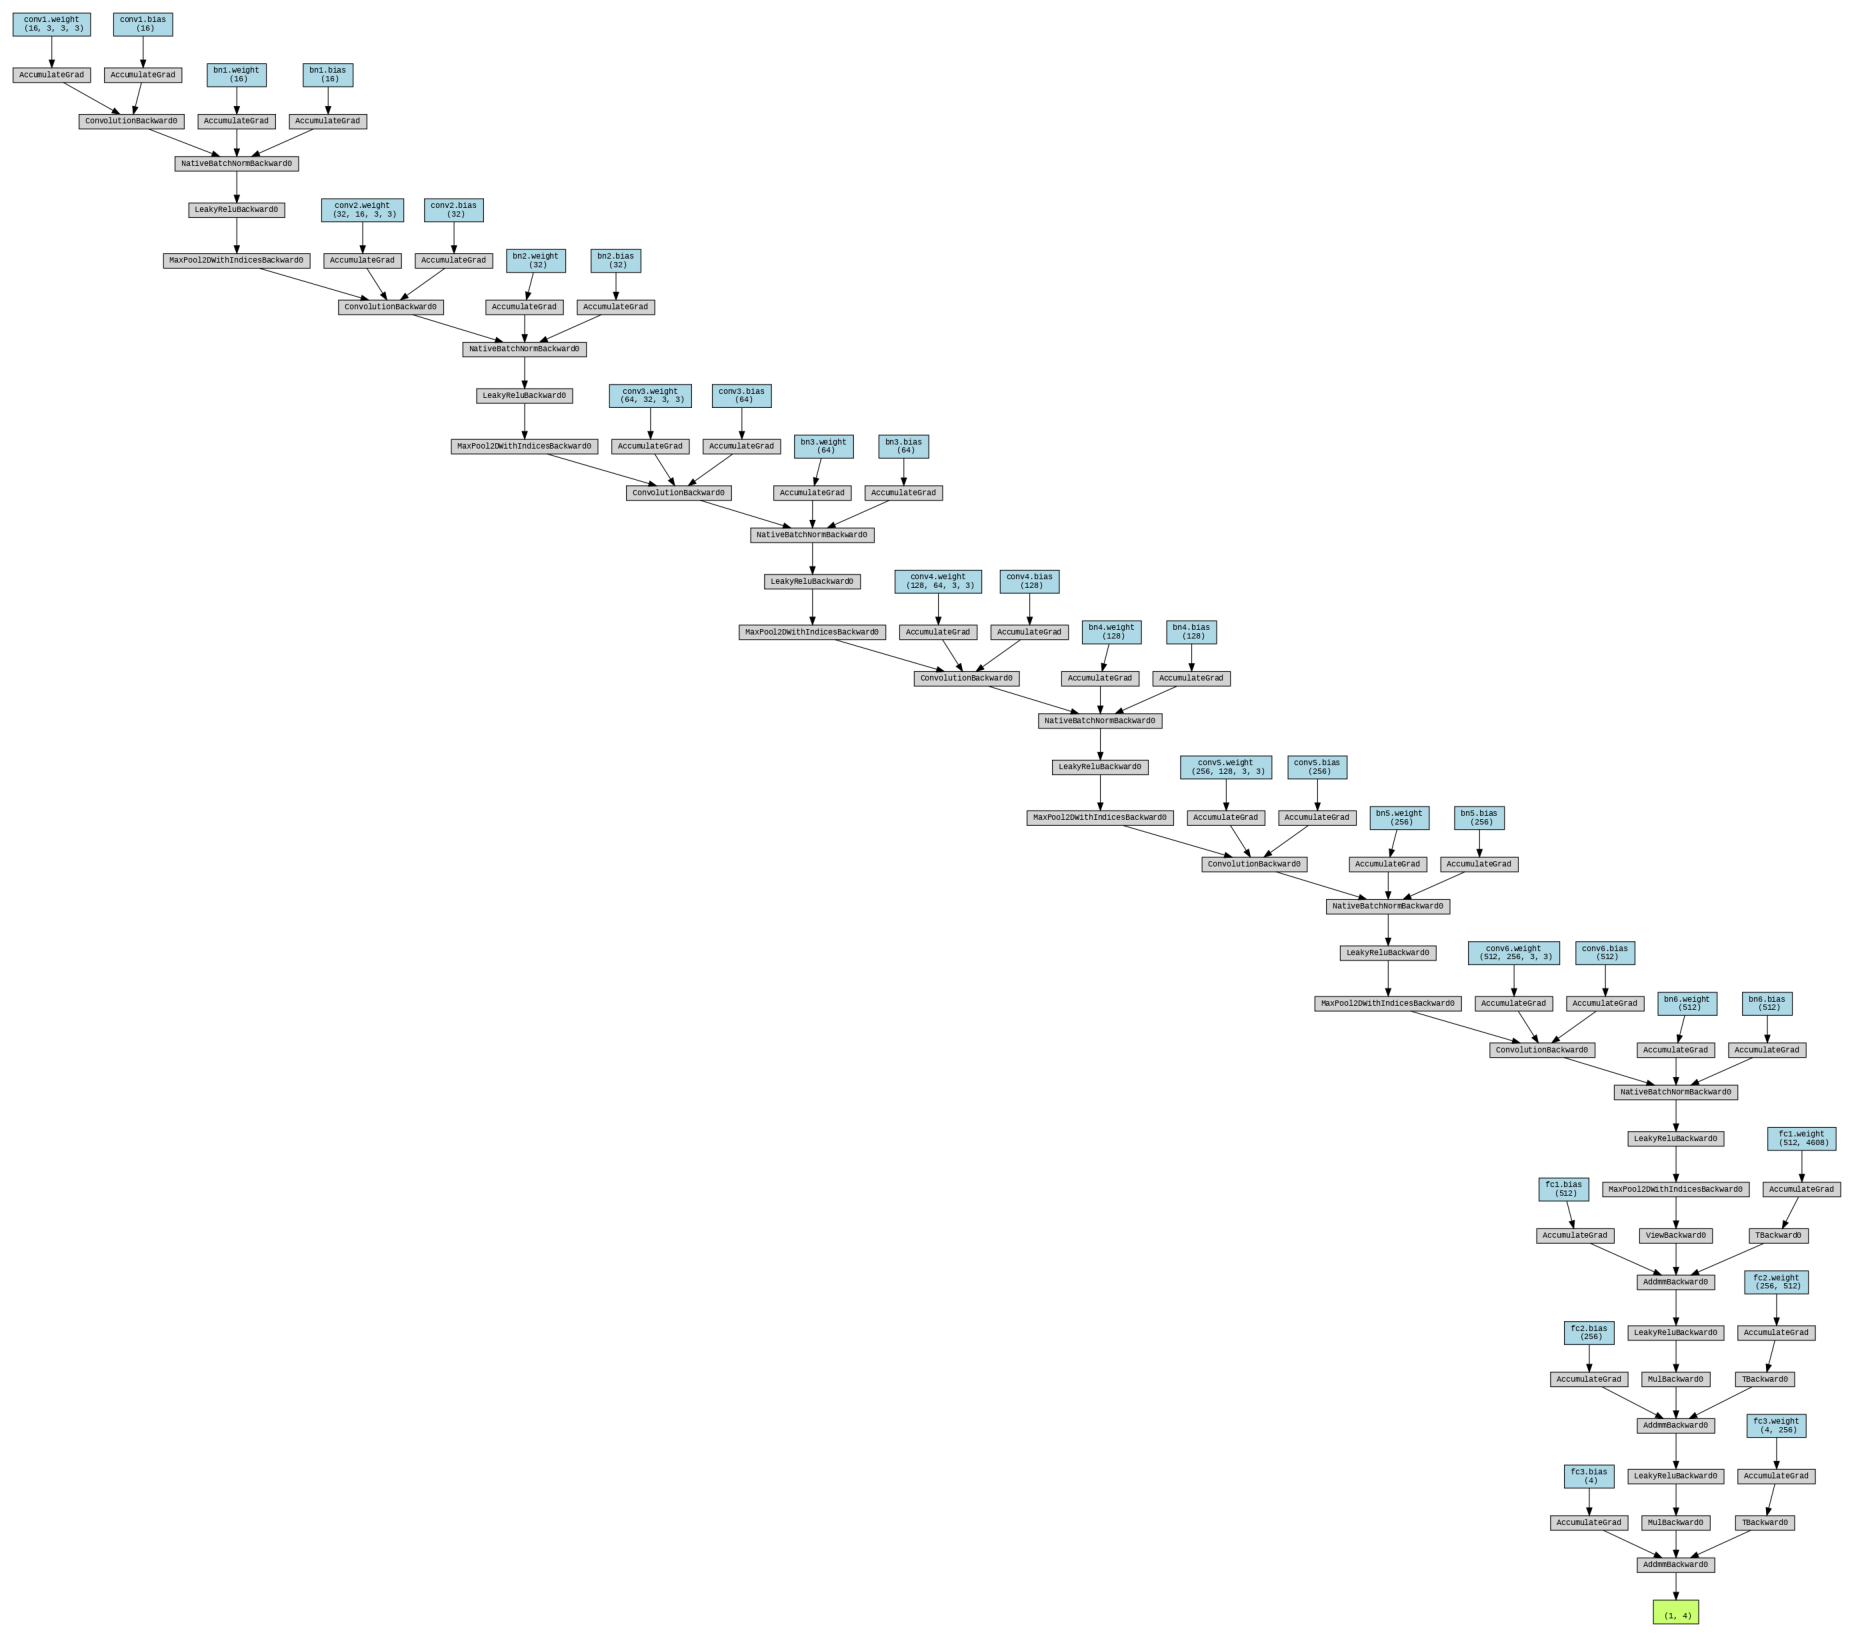

In [ ]:
# Create a dummy input
x = torch.randn(1, 3, 224, 224).to(device)  # Batch size of 1

# Get the output
y = Model1(x)

# Visualize the model
dot = make_dot(y, params=dict(list(Model1.named_parameters())))
dot.render("CNNAlzheimer", format="png")  # Save as PNG

# Display the image using matplotlib
img = mpimg.imread("CNNAlzheimer.png")
plt.figure(figsize=(35, 21))
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

In [ ]:

# Initialize model, loss, optimizer
model = Model2.to(device)

# handle class imbalance in test set
class_counts = train_df['label'].value_counts().values
class_weights = torch.tensor([sum(class_counts) / count for count in class_counts], dtype=torch.float32).to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.4, patience=2, verbose=True)


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:


# Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("Early stopping triggered")




In [ ]:

# Training Loop
num_epoch = 20
early_stopping = EarlyStopping(patience=5, verbose=True)
best_val_loss = float('inf')

In [ ]:
train_loss_list = []
val_loss_list = []
acc_list = []

#training

In [ ]:
# Initialize variables to save the best model
best_val_loss = float('inf')  # Start with infinity
best_model_weights = None

# Training loop
for epoch in range(num_epoch):
    train_loss = 0
    val_loss = 0
    total = 0
    correct = 0

    # Training phase
    model.train()  # Set model to training mode
    for images, labels in train_loader:
        optimizer.zero_grad()
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        train_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # Validation phase
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()

            # Calculate accuracy
            prediction = torch.max(outputs.data, 1)[1]
            total += len(labels)
            correct += (prediction == labels).sum().item()

    # Average losses
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    accuracy = 100 * correct / total

    # Step the scheduler based on validation loss
    scheduler.step(avg_val_loss)

    # Store losses and accuracy
    train_loss_list.append(avg_train_loss)
    val_loss_list.append(avg_val_loss)
    acc_list.append(accuracy)

    # Print metrics
    print('-' * 100)
    print(f'Epoch [{epoch + 1}/{num_epoch}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.2f}%')

    # Check if the current validation loss is the best we've seen so far
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_weights = model.state_dict()
        print("Best model weights saved.")

    # Check for early stopping
    early_stopping(avg_val_loss)
    if early_stopping.early_stop:
        print("Early stopping at epoch:", epoch + 1)
        break

# After training, save the best model weights to a file
torch.save(best_model_weights, 'best_model_weights.pth')
print("Best model weights saved.")


----------------------------------------------------------------------------------------------------
Epoch [1/20], Train Loss: 2.6537, Val Loss: 1.3654, Accuracy: 34.18%
Best model weights saved.
----------------------------------------------------------------------------------------------------
Epoch [2/20], Train Loss: 1.4422, Val Loss: 1.2748, Accuracy: 38.80%
Best model weights saved.
----------------------------------------------------------------------------------------------------
Epoch [3/20], Train Loss: 1.3946, Val Loss: 2.4648, Accuracy: 27.80%
----------------------------------------------------------------------------------------------------
Epoch [4/20], Train Loss: 1.3688, Val Loss: 1.3665, Accuracy: 46.94%


#evaluation

In [ ]:
# Initialize lists to store test losses and accuracies
test_loss_list = []  # Store test losses over epochs
test_accuracy_list = []  # Store test accuracies over epochs

# Test phase
model.eval()  # Set model to evaluation mode
test_loss = 0
total = 0
correct = 0
all_test_labels = []
all_test_predictions = []

with torch.no_grad():  # Disable gradient calculation
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = loss_fn(outputs, labels)
        test_loss += loss.item()

        prediction = torch.max(outputs.data, 1)[1]
        total += len(labels)
        correct += (prediction == labels).sum().item()  # Count correct predictions

        # Store labels and predictions for metrics
        all_test_labels.extend(labels.cpu().numpy())
        all_test_predictions.extend(prediction.cpu().numpy())

# Calculate average test loss and accuracy
test_accuracy = 100 * correct / total
test_loss_avg = test_loss / len(test_loader)
test_loss_list.append(test_loss_avg)
test_accuracy_list.append(test_accuracy)

# Print test results
print('-' * 100)
print(f'Test Loss: {test_loss_avg:.4f}, Test Accuracy: {test_accuracy:.2f}%')




In [ ]:
# Visualization of performance
# Convert to numpy arrays
y_true = np.array(all_test_labels)
y_pred = np.array(all_test_predictions)

# Generate classification report
from sklearn.metrics import classification_report, confusion_matrix
report = classification_report(y_true, y_pred)
print("Classification Report:")
print(report)

# Visualize Confusion Matrix
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_true, y_pred)
class_names = train_df['label'].unique()  # Get unique class names

plt.figure(figsize=(10, 7))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Set threshold for text color
thresh = conf_matrix.max() / 2.
for i, j in np.ndindex(conf_matrix.shape):
    plt.text(j, i, f'{conf_matrix[i, j]}',
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()